In [4]:
import numpy as np
import matplotlib.pyplot as plt
import utilities as ut
ut.init(use_latex=False)

# Simulates a single chain
def simulate(rng, num_steps, p_A_B, p_B_A):
    # define transition matrix
    T = [[1 - p_A_B,     p_A_B],
         [    p_B_A, 1 - p_B_A]]

    # states: 0 = A, 1 = B. Initial state is always "A"
    state_history = np.zeros(num_steps, dtype=int)
    
    # step num_steps times
    for n in range(0, num_steps-1):
        # sample a step S^n -> S^(n+1) using transition matrix
        state_history[n+1] = rng.choice(2, p=T[state_history[n]]) 
        
    return state_history

# Simulates several chains
def simulate_several_samples(rng, num_samples, num_steps, p_A_B, p_B_A):
    samples = np.zeros((num_samples, num_steps))
    for m in range(num_samples):
        samples[m] = simulate(RNG, num_steps, p_A_B, p_B_A)
    return samples

Once we define our simulator, we can run it to obtain some sample chains.

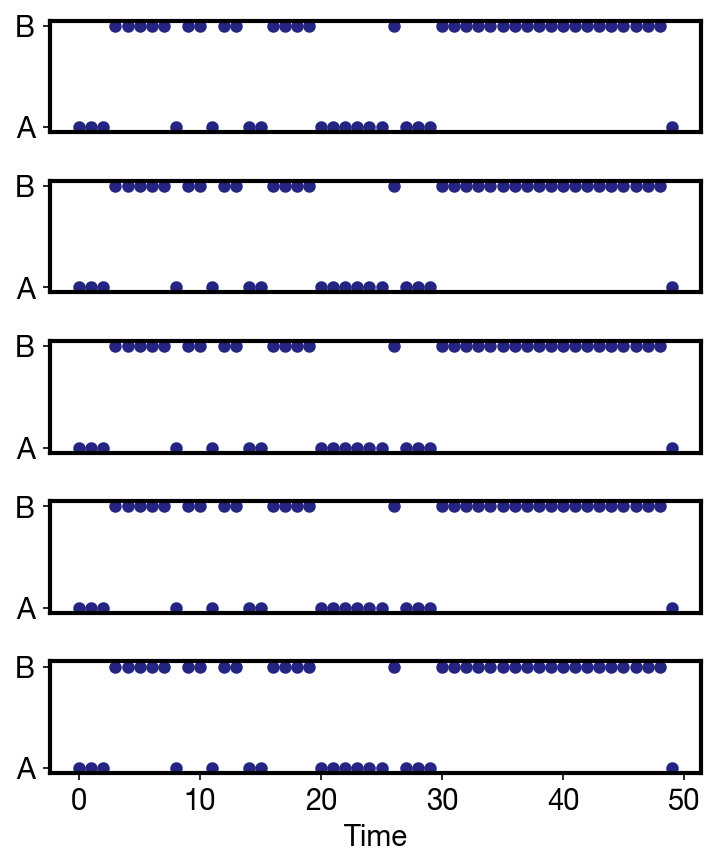

In [5]:
RNG = np.random.default_rng(seed = 12345)    

# Run the simulator several time to sample some chains
samples = simulate_several_samples(RNG, num_samples=1000, num_steps = 50, p_A_B = 0.5, p_B_A = 0.25)

# Plot the first few chains
plt.figure(figsize=(5,6))
for m in range(5):
    plt.subplot(5, 1, m+1)
    plt.plot(samples[0], marker='.', markersize=10, linewidth=0)
    
    plt.yticks([0,1], ['A', 'B'])
    
    # Only plot horizontal axis labels on last plot to save space
    if m < 4: 
        plt.xticks([])
    else:
        plt.xlabel('Time')
plt.tight_layout()

What is the impact of $p_{A,B}$ and $p_{B,A}$?

## Summary statistics from Monte Carlo samples

In [ ]:
plt.plot(np.mean(samples, axis=0), label='$p_B$')
plt.plot(1-np.mean(samples, axis=0), label='$p_A$')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend();

What is impact of $p_{A,B}$ and $p_{B,A}$?

In [ ]:
samples = simulate_several_samples(RNG, 
                                   num_samples=1000, 
                                   num_steps = 50, 
                                   p_A_B = 0.1, 
                                   p_B_A = 0.1)

plt.plot(1-np.mean(samples, axis=0), label='$[A]$')
plt.plot(np.mean(samples, axis=0), label='$[B]$')

plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend();

# Thermodynamics and equilibrium

In [ ]:
# Analytic solution
def equilibrium_concentration(p_A_B, p_B_A):
    # define transition matrix
    T = np.array([[1 - p_A_B,     p_A_B],
                  [    p_B_A, 1 - p_B_A]])
    
    # Calculate eigenvalues/vectors
    L, V = np.linalg.eig(T.T)
    
    # find the e.vector corresponding to e.value = 1
    if np.abs(L[0]-1) < 1e-6:
        idx = 0
    else:
        idx = 1
    
    # Return e.vector scaled so that sum = 1 (since this is a probability distribution)
    pi = V[:, idx].T / np.sum(V[:, idx].T)
    return pi

Let's compare the analytically derived equilibrium distribution with what we obtain using Monte Carlo sampling.

In [ ]:
P_A_B = 0.2
P_B_A = 0.1

# Analytically derived equilibrium concentration
pi = equilibrium_concentration(p_A_B = P_A_B, 
                               p_B_A = P_B_A)

# Monte Carlo samples
samples = simulate_several_samples(RNG, 
                                   num_samples=1000, 
                                   num_steps = 50, 
                                   p_A_B = P_A_B, 
                                   p_B_A = P_B_A)

# Plot Monte Carlo estimated mean
plt.plot(np.mean(1.0 - samples, axis=0), label='$[A]$')
plt.plot(np.mean(samples, axis=0), label='$[B]$')

# Plot analytically derived equilibrium concentration
plt.axhline(y=pi[0], linestyle=':', color = ut.COLORS[0], label = '$[A]_{eq}$')
plt.axhline(y=pi[1], linestyle=':', color = ut.COLORS[1], label = '$[B]_{eq}$')

plt.ylabel('Concentration')
plt.xlabel('Time')
plt.legend();

# Uncertainty quantification

In [ ]:
P_A_B = 0.2
P_B_A = 0.1
NUM_SAMPLES = 1000
NUM_STEPS = 50

pi = equilibrium_concentration(p_A_B = P_A_B, p_B_A = P_B_A)
samples = simulate_several_samples(RNG, 
                                   num_samples=NUM_SAMPLES, 
                                   num_steps=NUM_STEPS, 
                                   p_A_B = P_A_B, 
                                   p_B_A = P_B_A)

# Plot Monte-carlo estimated mean
time = np.arange(NUM_STEPS)
mu_A = np.mean(1 - samples, axis = 0)
sig_A = np.std(1 - samples, axis = 0)
plt.plot(time, mu_A, label='$[A]$')
plt.fill_between(time, mu_A + sig_A, mu_A - sig_A, 
                 label=None, color = ut.COLORS[0], alpha = 0.1)

mu_B = np.mean(samples, axis = 0)
sig_B = np.std(samples, axis = 0)
plt.plot(time, mu_B, label='$[B]$')
plt.fill_between(time, mu_B + sig_B, mu_B - sig_B, 
                 label=None, color = ut.COLORS[1], alpha = 0.1)

# Plot analytically derived equilibrium concentration
plt.axhline(y=pi[0], linestyle=':', color = ut.COLORS[0], label = '$[A]_{eq}$')
plt.axhline(y=pi[1], linestyle=':', color = ut.COLORS[1], label = '$[B]_{eq}$')

plt.xlabel('Time')
plt.legend();

# Next steps

We showed above that we can use Monte Carlo samples to estimate the equilibrium concentrations -- the asymptotic values as time goes to infinity (i.e. as we step the Markov Chain a large number of steps). Can we use Monte Carlo methods to approximate the *kinetics* of the reaction?


To do this, we need the notion of a clock -- to time how long we are in a state in units other than number of MC steps. This will also help us with modeling *multiple* reactions.